In [10]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
from glob import glob

# dilutions

In [329]:

def get_reads_per_ref_sorted_by_longest_alg(fn, mapq=20, flag=2324):
    """
    read unmapped (0x4)
    read reverse strand (0x10)
    not primary alignment (0x100)
    supplementary alignment (0x800)
    """
    sam = pysam.AlignmentFile(fn)
    refs = sam.references
    readids = []
    for ref in refs:
        id2alen = {a.qname: a.alen for a in sam.fetch(ref) if a.mapq>=mapq and not a.flag&flag}
        ids = sorted(id2alen, key=lambda x: id2alen[x], reverse=True)
        readids.append(ids)
    return readids

fn1 = "/no_backup/enovoa/users/lpryszcz/cluster/rna_mods/curlcake/modPhred/raw.m6A/minimap2/RNA081120181_unmodified.bam"
fn2 = "/no_backup/enovoa/users/lpryszcz/cluster/rna_mods/curlcake/modPhred/raw.m6A/minimap2/RNA081120182_m6A.bam"
readids1 = get_reads_per_ref_sorted_by_longest_alg(fn1)
readids2 = get_reads_per_ref_sorted_by_longest_alg(fn2)
sum(map(len, readids1)), sum(map(len, readids2)), list(map(len, readids1)), list(map(len, readids2))

(634222, 252679, [70647, 182826, 193953, 186796], [60406, 49957, 71631, 70685])

In [332]:
outdir = "dilutions"
if not os.path.isdir(outdir): os.makedirs(outdir)

n = 2000
dilutions = [0., 0.0625, 0.125, 0.25, 0.5, 1.]
for d in dilutions:
    n2 = int(round(d*n)) # m6A reads per ref
    n1 = n-n2 # unmod reads per ref
    fn = f"{outdir}/m6A_{d:6.4f}.ids".replace(" ", "0")
    print(d, n1, n2, fn)
    with open(fn, "wt") as out:
        for l1, l2 in zip(readids1, readids2):
            if n1: out.write("\n".join(l1[:n1]) + "\n")
            if n2: out.write("\n".join(l2[:n2]) + "\n")

0.0 2000 0 dilutions/m6A_0.0000.ids
0.0625 1875 125 dilutions/m6A_0.0625.ids
0.125 1750 250 dilutions/m6A_0.1250.ids
0.25 1500 500 dilutions/m6A_0.2500.ids
0.5 1000 1000 dilutions/m6A_0.5000.ids
1.0 0 2000 dilutions/m6A_1.0000.ids


## dilutions 1k for mafia

In [331]:
outdir = "dilutions_1k"
if not os.path.isdir(outdir): os.makedirs(outdir)

n = 1000
dilutions = [0., 0.0625, 0.125, 0.25, 0.5, 1.]
for d in dilutions:
    n2 = int(round(d*n)) # m6A reads per ref
    n1 = n-n2 # unmod reads per ref
    fn = f"{outdir}/m6A_{d:6.4f}.ids".replace(" ", "0")
    print(d, n1, n2, fn)
    with open(fn, "wt") as out:
        for l1, l2 in zip(readids1, readids2):
            if n1: out.write("\n".join(l1[:n1]) + "\n")
            if n2: out.write("\n".join(l2[:n2]) + "\n")

0.0 1000 0 dilutions_1k/m6A_0.0000.ids
0.0625 938 62 dilutions_1k/m6A_0.0625.ids
0.125 875 125 dilutions_1k/m6A_0.1250.ids
0.25 750 250 dilutions_1k/m6A_0.2500.ids
0.5 500 500 dilutions_1k/m6A_0.5000.ids
1.0 0 1000 dilutions_1k/m6A_1.0000.ids


# per site plots

In [1]:
bed = "curlcake.fa.bed"
positions = []
with open(bed, 'rt') as f:
    for i, l in enumerate(f):
        if not i: continue
        ref, s, e = l[:-1].split()[:3]
        s, e = int(s), int(e)
        positions.append((ref, s, e))
len(positions)

14

## m6ABC

[0.03126744835287549, 0.029081632653061223, 0.037851662404092073, 0.00501002004008016, 0.004543160020191822, 0.03919491525423729, 0.15462354724608388, 0.053931451612903226, 0.01256913021618904, 0.15129533678756477, 0.05271160669031931, 0.1694648478488982, 0.011622031328954016, 0.054647599591419814]
[0.08949416342412451, 0.07095115681233934, 0.09030271934325294, 0.050226017076845805, 0.044534412955465584, 0.09086078639744952, 0.19929006085192696, 0.09856996935648621, 0.06774519716885744, 0.18153200419727178, 0.10873983739837398, 0.20908130939809927, 0.06284845413076533, 0.09650924024640657]
[0.14823008849557523, 0.11335403726708075, 0.14093959731543623, 0.10145655449522853, 0.07809330628803246, 0.14025695931477516, 0.244794311833418, 0.14123711340206185, 0.1244286439817166, 0.21052631578947367, 0.16531027466937945, 0.2531847133757962, 0.1122397155916709, 0.1438178996378686]
[0.2605827377680044, 0.1953414505029116, 0.24095139607032057, 0.19748743718592965, 0.14409368635437883, 0.23920086

Text(0.5, 1.0, 'Per-positions predictions for 14 GGATC sites')

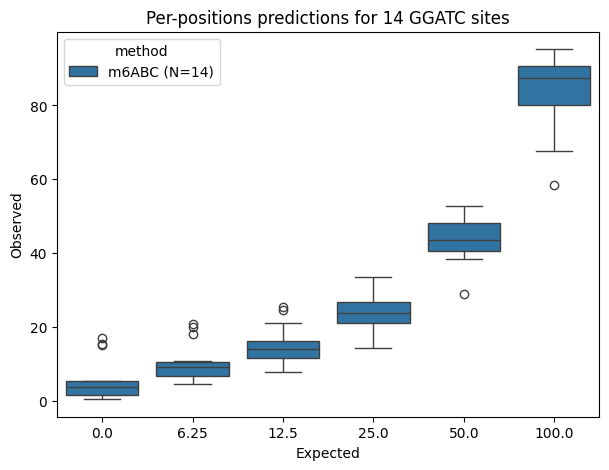

In [12]:
%%time
def get_modprob_per_pos(bam, pos2idx, max_baseq=30):
    """Return modification probabilities from modPhred"""
    sam = pysam.AlignmentFile(bam)
    probs = [[] for i in range(len(pos2idx))]
    for a in sam:
        for q, r in a.get_aligned_pairs(matches_only=True):
            pos = f"{a.reference_name}:{r}"
            if pos in pos2idx:
                probs[pos2idx[pos]].append(a.query_qualities[q]/max_baseq)
    probs = [np.array(p) for p in probs]
    return probs

# m6ABC
min_prob = 0.1
bampat = "/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/ModPhred/minimap2/m6A_*.bam"
bams = sorted(glob(bampat)); bams
pos2idx = {f"{ref}:{s}": i for i, (ref, s, e) in enumerate(positions)}

freqs = []
for bam in bams:
    probs = get_modprob_per_pos(bam, pos2idx)
    _freqs = [(p>=min_prob).mean() for p in probs]; print(_freqs)
    freqs.append(_freqs)

new_cols = [0, 6.25, 12.5, 25, 50, 100]
'''
fn = "/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/ModPhred/mod.gz"
bampat = "/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/ModPhred/minimap2/m6A_*.bam"
bams = sorted(glob(bampat)); bams

df = pd.read_csv(fn, sep='\t', skiprows=16); df.head()
## DRACH
cols = [c for c in df.columns if c.endswith("mod_frequency")]; 
pos = set(f"{ref}:{e}" for ref, s, e in positions); pos
sel = np.array([True if f"{r.chr}:{r.pos}" in pos else False for idx, r in df.iterrows()]); len(cols), len(pos), sel.sum()
df2 = df.loc[sel, cols] * 100
#freqs = df.loc[sel, cols].to_numpy(); freqs
df2 = df2.rename(columns={old: new for old, new in zip(df2.columns, new_cols)}); df2.head()
'''
_df2 = np.array(freqs).T * 100
_df2 = pd.DataFrame(_df2, columns=new_cols); 
_df2["method"] = f"m6ABC (N={_df2.shape[0]:,})"; _df2.head()
#dframes.append(_df2)
dframes = [_df2, ]

df3 = _df2.melt(["method"], var_name="Expected", value_name="Observed"); df3.head()
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df3, x="Expected", y="Observed", hue="method", ax=ax)
ax.set_title("Per-positions predictions for 14 GGATC sites")

## mafia

['dilutions_1k.out/m6A_0.0000/mAFiA.GGACT.sites.bed', 'dilutions_1k.out/m6A_0.0625/mAFiA.GGACT.sites.bed', 'dilutions_1k.out/m6A_0.1250/mAFiA.GGACT.sites.bed', 'dilutions_1k.out/m6A_0.2500/mAFiA.GGACT.sites.bed', 'dilutions_1k.out/m6A_0.5000/mAFiA.GGACT.sites.bed', 'dilutions_1k.out/m6A_1.0000/mAFiA.GGACT.sites.bed']


Text(0.5, 1.0, 'Per-positions predictions for 14 GGATC sites')

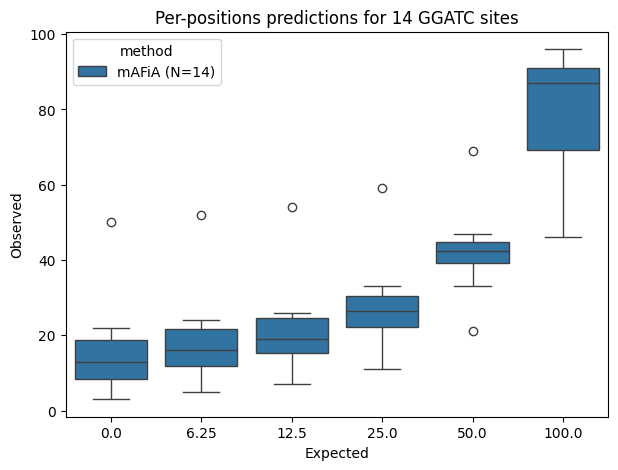

In [13]:
pat = "dilutions.out/m6A_*/mAFiA.GGACT.sites.bed"
pat = "dilutions_1k.out/m6A_*/mAFiA.GGACT.sites.bed"
fnames = sorted(glob(pat)); print(fnames)
_df2 = []
for fn in fnames:
    with open(fn, "rt") as f:
        _df2.append([])
        for i, l in enumerate(f):
            if not i: continue
            ldata = l[:-1].split()
            ref, s, e = ldata[:3]
            mod_freq = float(ldata[-2])
            _df2[-1].append(mod_freq)
_df2 = np.array(_df2).T
_df2 = pd.DataFrame(_df2, columns=new_cols); 
_df2["method"] = f"mAFiA (N={_df2.shape[0]:,})"; _df2.head()
dframes.append(_df2)

df3 = _df2.melt(["method"], var_name="Expected", value_name="Observed"); df3.head()
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df3, x="Expected", y="Observed", hue="method", ax=ax)
ax.set_title("Per-positions predictions for 14 GGATC sites")

## m6Anet

['/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/m6Anet/step3_inference_2k_reads/m6A_0.0000/data.site_proba.csv', '/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/m6Anet/step3_inference_2k_reads/m6A_0.0625/data.site_proba.csv', '/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/m6Anet/step3_inference_2k_reads/m6A_0.1250/data.site_proba.csv', '/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/m6Anet/step3_inference_2k_reads/m6A_0.2500/data.site_proba.csv', '/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/m6Anet/step3_inference_2k_reads/m6A_0.5000/data.site_proba.csv', '/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/m6Anet/step3_inference_2k_reads/m6A_1.0000/data.site_proba.csv']


Text(0.5, 1.0, 'Per-positions predictions for 14 GGATC sites')

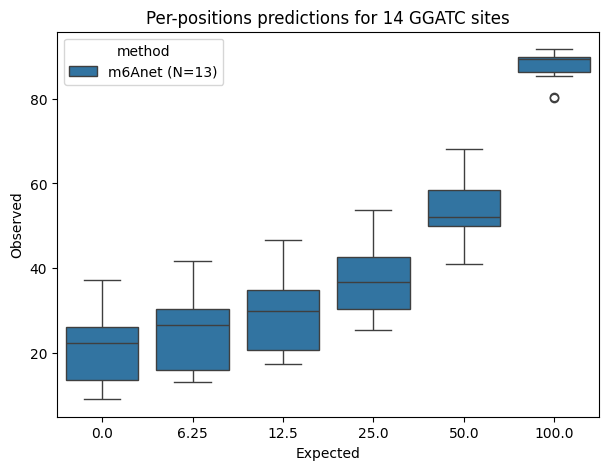

In [14]:
pos = set(f"{ref}:{s}" for ref, s, e in positions); pos
pat = "/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/m6Anet/step3_inference/m6A_*/data.site_proba.csv"
pat = "/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/m6Anet/step3_inference_2k_reads/m6A_*/data.site_proba.csv"

fnames = sorted(glob(pat)); print(fnames)
_df2 = []
for fn in fnames:
    with open(fn, "rt") as f:
        _df2.append([])
        for i, l in enumerate(f):
            if not i: continue
            ldata = l[:-1].split(",")
            if ":".join(ldata[:2]) in pos:
                mod_freq = float(ldata[-1])*100
                _df2[-1].append(mod_freq)
_df2 = np.array(_df2).T
_df2 = pd.DataFrame(_df2, columns=new_cols); 
_df2["method"] = f"m6Anet (N={_df2.shape[0]:,})"; _df2.head()
dframes.append(_df2)

df3 = _df2.melt(["method"], var_name="Expected", value_name="Observed"); df3.head()
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df3, x="Expected", y="Observed", hue="method", ax=ax)
ax.set_title("Per-positions predictions for 14 GGATC sites")

## cheui

In [31]:
pos2idx

{'cc6m_2244_T7_ecorv:102': 0,
 'cc6m_2244_T7_ecorv:687': 1,
 'cc6m_2244_T7_ecorv:1386': 2,
 'cc6m_2244_T7_ecorv:1965': 3,
 'cc6m_2459_T7_ecorv:333': 4,
 'cc6m_2459_T7_ecorv:823': 5,
 'cc6m_2459_T7_ecorv:1700': 6,
 'cc6m_2595_T7_ecorv:399': 7,
 'cc6m_2595_T7_ecorv:610': 8,
 'cc6m_2595_T7_ecorv:1370': 9,
 'cc6m_2595_T7_ecorv:1867': 10,
 'cc6m_2595_T7_ecorv:2605': 11,
 'cc6m_2709_T7_ecorv:1865': 12,
 'cc6m_2709_T7_ecorv:1973': 13}

['/no_backup/enovoa/users/andelgado/m6A_basecaller_benchmark_mixtures/NanoMod/nanopolish-compore_flow/event_align/CHEUI/Results/Site_Predictions_m6A_0.0000.txt', '/no_backup/enovoa/users/andelgado/m6A_basecaller_benchmark_mixtures/NanoMod/nanopolish-compore_flow/event_align/CHEUI/Results/Site_Predictions_m6A_0.0625.txt', '/no_backup/enovoa/users/andelgado/m6A_basecaller_benchmark_mixtures/NanoMod/nanopolish-compore_flow/event_align/CHEUI/Results/Site_Predictions_m6A_0.1250.txt', '/no_backup/enovoa/users/andelgado/m6A_basecaller_benchmark_mixtures/NanoMod/nanopolish-compore_flow/event_align/CHEUI/Results/Site_Predictions_m6A_0.2500.txt', '/no_backup/enovoa/users/andelgado/m6A_basecaller_benchmark_mixtures/NanoMod/nanopolish-compore_flow/event_align/CHEUI/Results/Site_Predictions_m6A_0.5000.txt', '/no_backup/enovoa/users/andelgado/m6A_basecaller_benchmark_mixtures/NanoMod/nanopolish-compore_flow/event_align/CHEUI/Results/Site_Predictions_m6A_1.0000.txt']
/no_backup/enovoa/users/andelgado

Text(0.5, 1.0, 'Per-positions predictions for 14 GGATC sites')

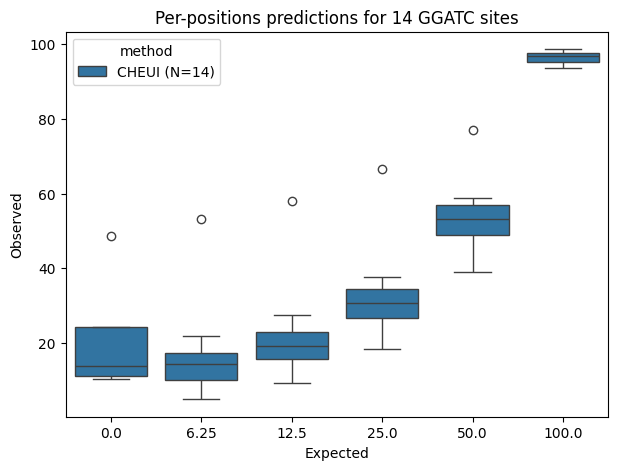

In [49]:
pat = "/no_backup/enovoa/users/andelgado/m6A_basecaller_benchmark_mixtures/NanoMod/nanopolish-compore_flow/event_align/CHEUI/Results/Site_Predictions_m6A_*.txt"
fnames = sorted(glob(pat)); print(fnames)
freqs = []
for fn in fnames:
    print(fn)
    freqs.append([-1 for i in range(len(pos2idx))])
    with open(fn, "rt") as f:
        for i, l in enumerate(f):
            if not i: continue
            ldata = l[:-1].split()
            pos = f"{ldata[0]}:{int(ldata[1])+4}"
            if pos in pos2idx:
                mod_freq = float(ldata[-2])*100
                freqs[-1][pos2idx[pos]] = mod_freq
_df2 = np.array(freqs).T
_df2[_df2<0]=np.nan
_df2 = pd.DataFrame(_df2, columns=new_cols); 
_df2["method"] = f"CHEUI (N={_df2.shape[0]:,})"; _df2.head()
dframes.append(_df2)

df3 = _df2.melt(["method"], var_name="Expected", value_name="Observed"); df3.head()
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df3, x="Expected", y="Observed", hue="method", ax=ax)
ax.set_title("Per-positions predictions for 14 GGATC sites")

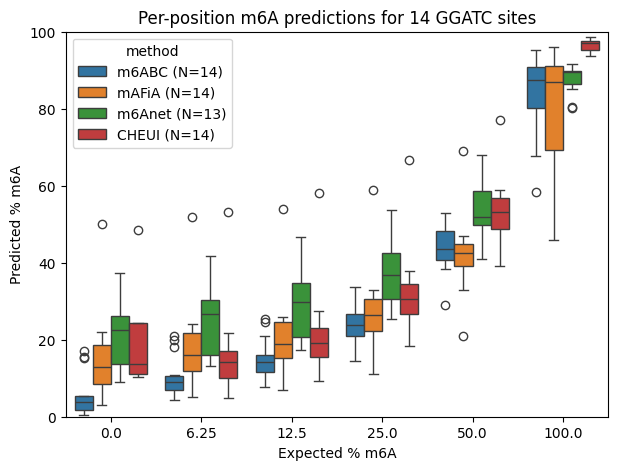

In [50]:
df2 = pd.concat(dframes)

df3 = df2.melt(["method"], var_name="Expected", value_name="Observed"); df3.head()
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df3, x="Expected", y="Observed", hue="method", ax=ax)
ax.set_xlabel("Expected % m6A")
ax.set_ylabel("Predicted % m6A")
ax.set_title("Per-position m6A predictions for 14 GGATC sites")
ax.set_ylim(0, 100)
fig.savefig("per-position.CC.GGACT.pdf")

### m6ABC vs m6Anet: KGACY

['/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/m6Anet/step3_inference_2k_reads/m6A_0.0000/data.site_proba.csv', '/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/m6Anet/step3_inference_2k_reads/m6A_0.0625/data.site_proba.csv', '/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/m6Anet/step3_inference_2k_reads/m6A_0.1250/data.site_proba.csv', '/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/m6Anet/step3_inference_2k_reads/m6A_0.2500/data.site_proba.csv', '/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/m6Anet/step3_inference_2k_reads/m6A_0.5000/data.site_proba.csv', '/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/m6Anet/step3_inference_2k_reads/m6A_1.0000/data.site_proba.csv']


Text(0.5, 1.0, 'Per-positions predictions for 41 KGACY sites')

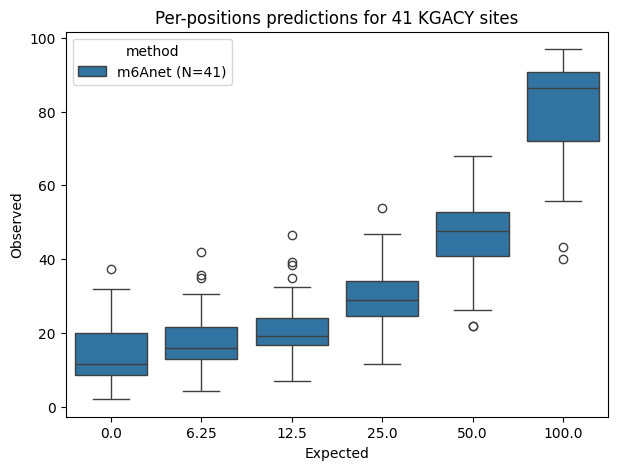

In [430]:
pat = "/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/m6Anet/step3_inference/m6A_*/data.site_proba.csv"
pat = "/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/m6Anet/step3_inference_2k_reads/m6A_*/data.site_proba.csv"

new_cols = [0, 6.25, 12.5, 25, 50, 100]
dframes = []
pos = []
fnames = sorted(glob(pat)); print(fnames)
_df2 = []
for fn in fnames:
    with open(fn, "rt") as f:
        _df2.append([])
        for i, l in enumerate(f):
            if not i: continue
            ldata = l[:-1].split(",")
            #if ":".join(ldata[:2]) in pos:
            mer, mod_freq = ldata[-2:]
            if mer[2]=="A" and mer.count("A")==1:
                mod_freq = float(mod_freq)*100
                _df2[-1].append(mod_freq)
                p = ":".join(ldata[:2])
                if p not in pos: pos.append(p)
_df2 = np.array(_df2).T
_df2 = pd.DataFrame(_df2, columns=new_cols); 
_df2["pos"] = pos
_df2 = _df2.set_index("pos")
_df2.to_csv("per-position.CC.m6Anet.KGACY.tsv", sep='\t') #  m6ABC
_df2["method"] = f"m6Anet (N={_df2.shape[0]:,})"; _df2.head()
dframes.append(_df2)

df3 = _df2.melt(["method"], var_name="Expected", value_name="Observed"); df3.head()
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df3, x="Expected", y="Observed", hue="method", ax=ax)
ax.set_title(f"Per-positions predictions for {len(pos)} KGACY sites")

[0.008559919436052367, 0.03126744835287549, 0.011610297829379102, 0.029081632653061223, 0.037851662404092073, 0.0, 0.007767995857068877, 0.00501002004008016, 0.0005202913631633715, 0.019427402862985686, 0.004543160020191822, 0.008564231738035265, 0.009615384615384616, 0.03919491525423729, 0.005115089514066497, 0.15462354724608388, 0.012556504269211451, 0.053931451612903226, 0.017757483510908167, 0.0005053057099545225, 0.01256913021618904, 0.0015274949083503055, 0.021352313167259787, 0.0020376974019358125, 0.0025627883136852894, 0.15129533678756477, 0.047136340598074, 0.0005083884087442806, 0.0005141388174807198, 0.014705882352941176, 0.05271160669031931, 0.001540041067761807, 0.1694648478488982, 0.010931806350858927, 0.0005208333333333333, 0.00101010101010101, 0.0020335536349771225, 0.0005083884087442806, 0.013853258081067214, 0.0005058168942842691, 0.011622031328954016]
[0.05412240768841679, 0.08949416342412451, 0.04849412965798877, 0.07095115681233934, 0.09030271934325294, 0.01316455

Text(0.5, 1.0, 'Per-positions predictions for 41 KGACY sites')

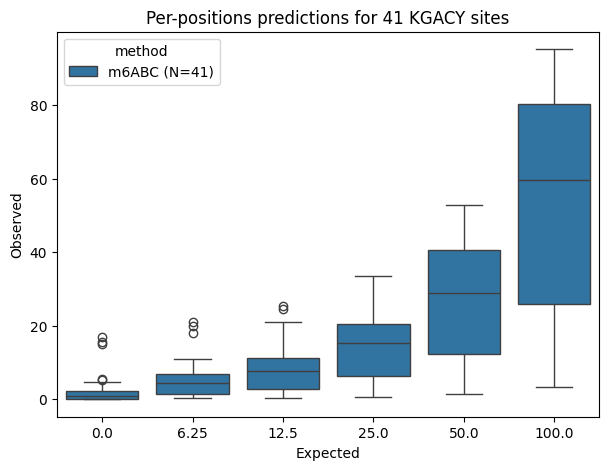

In [431]:
%%time
def get_modprob_per_pos(bam, pos2idx, max_baseq=30):
    """Return modification probabilities from modPhred"""
    sam = pysam.AlignmentFile(bam)
    probs = [[] for i in range(len(pos2idx))]
    for a in sam:
        for q, r in a.get_aligned_pairs(matches_only=True):
            pos = f"{a.reference_name}:{r}"
            if pos in pos2idx:
                probs[pos2idx[pos]].append(a.query_qualities[q]/max_baseq)
    probs = [np.array(p) for p in probs]
    return probs

# m6ABC
min_prob = 0.1
bampat = "/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/ModPhred/minimap2/m6A_*.bam"
bams = sorted(glob(bampat)); bams
pos2idx = {p: i for i, p in enumerate(pos)} #pos2idx = {f"{ref}:{s}": i for i, (ref, s, e) in enumerate(positions)}

freqs = []
for bam in bams:
    probs = get_modprob_per_pos(bam, pos2idx)
    _freqs = [(p>=min_prob).mean() for p in probs]; print(_freqs)
    freqs.append(_freqs)


_df2 = np.array(freqs).T * 100
_df2 = pd.DataFrame(_df2, columns=new_cols); 
_df2["pos"] = pos
_df2 = _df2.set_index("pos")
_df2.to_csv("per-position.CC.m6ABC.KGACY.tsv", sep='\t') #  m6ABC
_df2["method"] = f"m6ABC (N={_df2.shape[0]:,})"; _df2.head()
dframes.insert(0, _df2)

df3 = _df2.melt(["method"], var_name="Expected", value_name="Observed"); df3.head()
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df3, x="Expected", y="Observed", hue="method", ax=ax)
ax.set_title(f"Per-positions predictions for {len(pos)} KGACY sites")

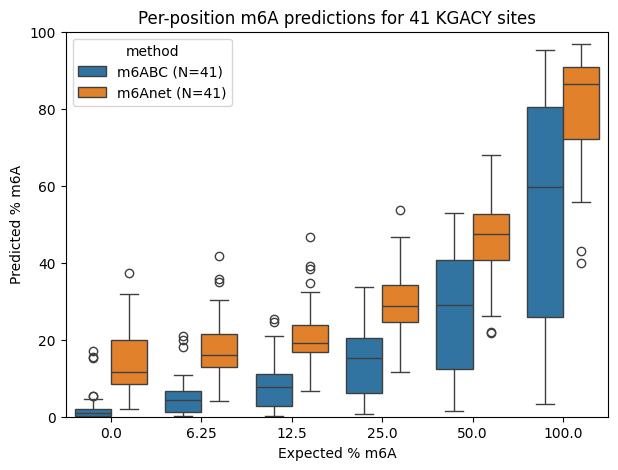

In [432]:
df2 = pd.concat(dframes)

df3 = df2.melt(["method"], var_name="Expected", value_name="Observed"); df3.head()
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df3, x="Expected", y="Observed", hue="method", ax=ax)
ax.set_xlabel("Expected % m6A")
ax.set_ylabel("Predicted % m6A")
ax.set_title(f"Per-position m6A predictions for {len(pos)} KGACY sites")
ax.set_ylim(0, 100)
fig.savefig("per-position.CC.m6ABC_m6Anet.KGACY.pdf") # GGACT

[0.03126744835287549, 0.029081632653061223, 0.037851662404092073, 0.00501002004008016, 0.004543160020191822, 0.03919491525423729, 0.15462354724608388, 0.053931451612903226, 0.01256913021618904, 0.15129533678756477, 0.05271160669031931, 0.1694648478488982, 0.011622031328954016]
[0.08949416342412451, 0.07095115681233934, 0.09030271934325294, 0.050226017076845805, 0.044534412955465584, 0.09086078639744952, 0.19929006085192696, 0.09856996935648621, 0.06774519716885744, 0.18153200419727178, 0.10873983739837398, 0.20908130939809927, 0.06284845413076533]
[0.14823008849557523, 0.11335403726708075, 0.14093959731543623, 0.10145655449522853, 0.07809330628803246, 0.14025695931477516, 0.244794311833418, 0.14123711340206185, 0.1244286439817166, 0.21052631578947367, 0.16531027466937945, 0.2531847133757962, 0.1122397155916709]
[0.2605827377680044, 0.1953414505029116, 0.24095139607032057, 0.19748743718592965, 0.14409368635437883, 0.23920086393088552, 0.3302705461970393, 0.22804232804232805, 0.236252545

Text(0.5, 1.0, 'Per-positions predictions for 13 GGACT sites')

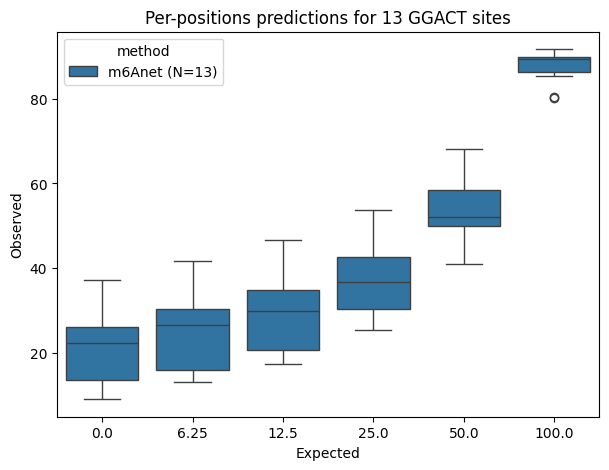

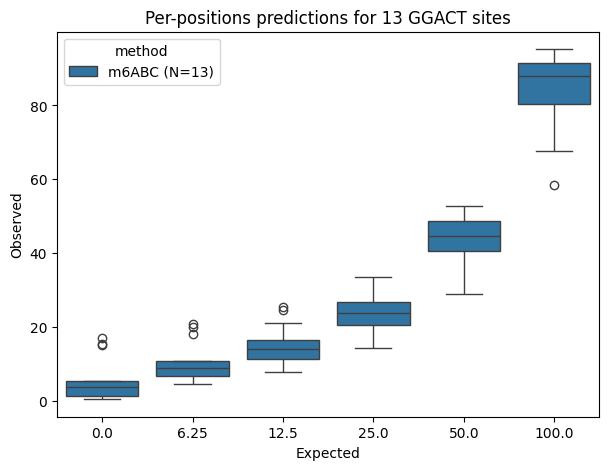

In [428]:
dframes = []
pos = []
_df2 = []
for fn in fnames:
    with open(fn, "rt") as f:
        _df2.append([])
        for i, l in enumerate(f):
            if not i: continue
            ldata = l[:-1].split(",")
            #if ":".join(ldata[:2]) in pos:
            mer, mod_freq = ldata[-2:]
            if mer=="GGACT":
                mod_freq = float(mod_freq)*100
                _df2[-1].append(mod_freq)
                p = ":".join(ldata[:2])
                if p not in pos: pos.append(p)
_df2 = np.array(_df2).T
_df2 = pd.DataFrame(_df2, columns=new_cols); 
_df2["pos"] = pos
_df2 = _df2.set_index("pos")
_df2.to_csv("per-position.CC.m6Anet.GGACT.tsv", sep='\t') #  m6ABC
_df2["method"] = f"m6Anet (N={_df2.shape[0]:,})"; _df2.head()
dframes.append(_df2)

df3 = _df2.melt(["method"], var_name="Expected", value_name="Observed"); df3.head()
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df3, x="Expected", y="Observed", hue="method", ax=ax)
ax.set_title(f"Per-positions predictions for {len(pos)} GGACT sites")

pos2idx = {p: i for i, p in enumerate(pos)} #pos2idx = {f"{ref}:{s}": i for i, (ref, s, e) in enumerate(positions)}

freqs = []
for bam in bams:
    probs = get_modprob_per_pos(bam, pos2idx)
    _freqs = [(p>=min_prob).mean() for p in probs]; print(_freqs)
    freqs.append(_freqs)

_df2 = np.array(freqs).T * 100
_df2 = pd.DataFrame(_df2, columns=new_cols); 
_df2["pos"] = pos
_df2 = _df2.set_index("pos")
_df2.to_csv("per-position.CC.m6ABC.GGACT.tsv", sep='\t') 
_df2["method"] = f"m6ABC (N={_df2.shape[0]:,})"; _df2.head()
dframes.insert(0, _df2)

df3 = _df2.melt(["method"], var_name="Expected", value_name="Observed"); df3.head()
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df3, x="Expected", y="Observed", hue="method", ax=ax)
ax.set_title(f"Per-positions predictions for {len(pos)} GGACT sites")

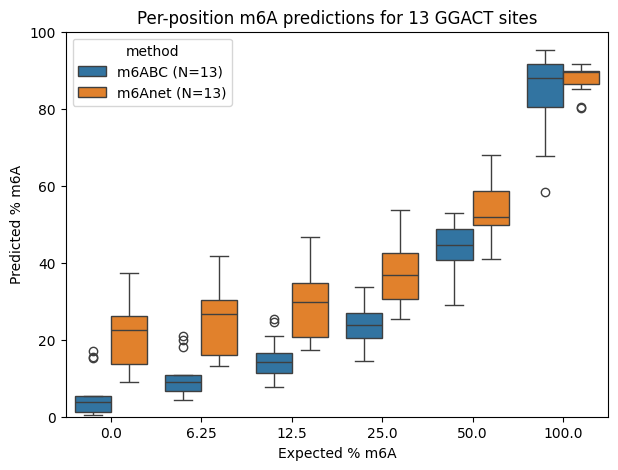

In [429]:
df2 = pd.concat(dframes)

df3 = df2.melt(["method"], var_name="Expected", value_name="Observed"); df3.head()
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df3, x="Expected", y="Observed", hue="method", ax=ax)
ax.set_xlabel("Expected % m6A")
ax.set_ylabel("Predicted % m6A")
ax.set_title(f"Per-position m6A predictions for {len(pos)} GGACT sites")
ax.set_ylim(0, 100)
fig.savefig("per-position.CC.m6ABC_m6Anet.GGACT.pdf") # 

### per-read

In [266]:
%%time
def get_modprob(bam, ref2pos, max_baseq=30):
    """Return modification probabilities from modPhred"""
    sam = pysam.AlignmentFile(bam)
    baseq = []
    for a in sam:
        if a.reference_name not in ref2pos: continue
        for q, r in a.get_aligned_pairs(matches_only=True):
            if r in ref2pos[a.reference_name]:
                baseq.append(a.query_qualities[q])
    p = np.array(baseq)/max_baseq
    return p

ref2pos = {}
for ref, s, e in positions:
    if ref not in ref2pos: ref2pos[ref] = set()
    ref2pos[ref].add(s)
ref2pos

# m6ABC
bampat = "/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes_mixtures_leszek/ModPhred/minimap2/m6A_*.bam"
bams = sorted(glob(bampat)); bams

unmod = get_modprob(bams[0], ref2pos) # unmod
mod = get_modprob(bams[-1], ref2pos) # mod
len(unmod), len(mod)

CPU times: user 10.6 s, sys: 0 ns, total: 10.6 s
Wall time: 10.6 s


(27269, 25420)

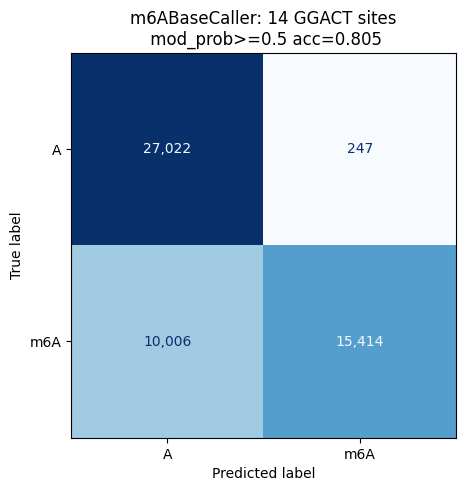

In [295]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

minp = 0.5
cm = np.zeros((2, 2), dtype='int')
cm[0, 0] = (unmod<minp).sum()
cm[0, 1] = (unmod>=minp).sum()
cm[1, 0] = (mod<minp).sum()
cm[1, 1] = (mod>=minp).sum()
acc = np.round(np.diag(cm).sum()/cm.sum(), 3); acc

n = 5
fig, ax = plt.subplots(figsize=(n, n))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "m6A"])
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format=',d')
ax.set_title(f"m6ABaseCaller: {len(positions)} GGACT sites\n mod_prob>={minp} acc={acc:.3f}")
fig.savefig(f"m6ABC.cm.GGACT.{minp}.pdf")

In [309]:
%%time
def get_modprob_ml(bam, ref2pos, max_baseq=255):
    """Return modification probabilities from modPhred"""
    sam = pysam.AlignmentFile(bam)
    baseq = []
    for a in sam:
        if a.reference_name not in ref2pos: continue
        if not a.modified_bases: continue
        q2r = {q: r for q, r in a.get_aligned_pairs(matches_only=True) if r in ref2pos[a.reference_name]}; q2r
        for (base, strand, modification), pos_qual in a.modified_bases.items():
            if strand != a.is_reverse:
                print("disagreement here, get reverse complement of modification info for %s"%a.qname)
                continue
            # store
            for pos, qual in pos_qual:
                # (256*probability), or -1 if unknown.
                if pos in q2r:
                    #m2prob[(base, modification)][len(read_ids), q2r[pos]] = qual
                    baseq.append(qual)
    p = np.array(baseq)/max_baseq
    return p

# mafia
pat = "dilutions.out/m6A_*/mAFiA.GGACT.reads.bam"
bams = sorted(glob(pat)); print(bams)

unmod = get_modprob_ml(bams[0], ref2pos) # unmod
mod = get_modprob_ml(bams[-1], ref2pos) # mod
#len(unmod), len(mod)

['dilutions.out/m6A_0.0000/mAFiA.GGACT.reads.bam', 'dilutions.out/m6A_0.0625/mAFiA.GGACT.reads.bam', 'dilutions.out/m6A_0.1250/mAFiA.GGACT.reads.bam', 'dilutions.out/m6A_0.2500/mAFiA.GGACT.reads.bam', 'dilutions.out/m6A_0.5000/mAFiA.GGACT.reads.bam', 'dilutions.out/m6A_1.0000/mAFiA.GGACT.reads.bam']


[W::bam_next_basemod] MM tag refers to bases beyond sequence length
[W::bam_next_basemod] MM tag refers to bases beyond sequence length
[W::bam_next_basemod] MM tag refers to bases beyond sequence length
[W::bam_next_basemod] MM tag refers to bases beyond sequence length
[W::bam_next_basemod] MM tag refers to bases beyond sequence length
[W::bam_next_basemod] MM tag refers to bases beyond sequence length
[W::bam_next_basemod] MM tag refers to bases beyond sequence length
[W::bam_next_basemod] MM tag refers to bases beyond sequence length
[W::bam_next_basemod] MM tag refers to bases beyond sequence length
[W::bam_next_basemod] MM tag refers to bases beyond sequence length
[W::bam_next_basemod] MM tag refers to bases beyond sequence length
[W::bam_next_basemod] MM tag refers to bases beyond sequence length
[W::bam_next_basemod] MM tag refers to bases beyond sequence length
[W::bam_next_basemod] MM tag refers to bases beyond sequence length


CPU times: user 6.64 s, sys: 0 ns, total: 6.64 s
Wall time: 6.73 s


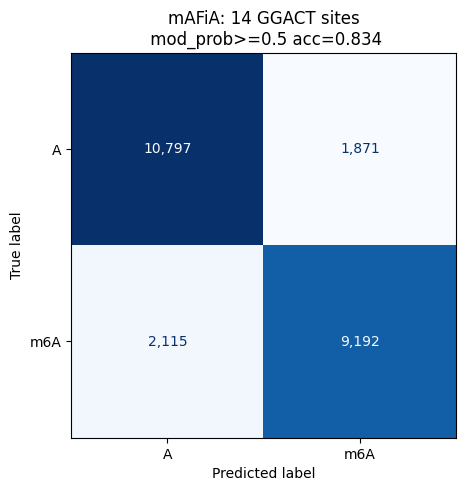

In [310]:
method = "mAFiA"
minp = 0.5
cm = np.zeros((2, 2), dtype='int')
cm[0, 0] = (unmod<minp).sum()
cm[0, 1] = (unmod>=minp).sum()
cm[1, 0] = (mod<minp).sum()
cm[1, 1] = (mod>=minp).sum()
acc = np.round(np.diag(cm).sum()/cm.sum(), 3); acc

n = 5
fig, ax = plt.subplots(figsize=(n, n))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "m6A"])
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format=',d')
ax.set_title(f"{method}: {len(positions)} GGACT sites\n mod_prob>={minp} acc={acc:.3f}")
fig.savefig(f"{method}.cm.GGACT.{minp}.pdf")

In [ ]:
# m6Anet


# m6Anet

In [172]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [19]:
fn = "/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes/m6Anet/m6A_net/MOD_GGACT_sites.txt"
cols = ["ref", "pos", "idx1", "idx2", "idx3", "idx4"]
df = pd.read_csv(fn, sep="\t", names=cols); df.head()

,ref,pos,idx1,idx2,idx3,idx4
0,cc6m_2244_T7_ecorv,102,59,0.995082,GGACT,0.898305
1,cc6m_2244_T7_ecorv,687,99,0.979512,GGACT,0.797980
2,cc6m_2244_T7_ecorv,1386,167,0.991944,GGACT,0.880240
3,cc6m_2244_T7_ecorv,1965,196,0.922915,GGACT,0.714286
4,cc6m_2459_T7_ecorv,333,91,0.972901,GGACT,0.824176


In [22]:
positions = df[df.columns[:2]].to_numpy(); positions

array([['cc6m_2244_T7_ecorv', 102],
       ['cc6m_2244_T7_ecorv', 687],
       ['cc6m_2244_T7_ecorv', 1386],
       ['cc6m_2244_T7_ecorv', 1965],
       ['cc6m_2459_T7_ecorv', 333],
       ['cc6m_2459_T7_ecorv', 823],
       ['cc6m_2459_T7_ecorv', 1700],
       ['cc6m_2595_T7_ecorv', 399],
       ['cc6m_2595_T7_ecorv', 610],
       ['cc6m_2595_T7_ecorv', 1370],
       ['cc6m_2595_T7_ecorv', 1867],
       ['cc6m_2595_T7_ecorv', 2605],
       ['cc6m_2709_T7_ecorv', 1865],
       ['cc6m_2709_T7_ecorv', 1973]], dtype=object)

In [33]:
fn = "/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes/m6Anet/m6A_net/UNM_inference/data.indiv_proba.csv"
df = pd.read_csv(fn); 
fn2 = "/no_backup/enovoa/users/scruciani/m6A_basecaller_benchmark/m6Anet_curlcakes/m6Anet/m6A_net/MOD_inference/data.indiv_proba.csv"
df2 = pd.read_csv(fn2); df.shape, df2.shape

((60099, 4), (29882, 4))

In [49]:
min_prob = 0.0333
print("#ref\tpos\treads unmod\tmodified frac unmod\treads m6A\tmodified frac m6A")
freqs = [[], []]
for ref, pos in positions:
    sel = (df["transcript_id"]==ref)&(df["transcript_position"]==pos); 
    mod_freq = (df.loc[sel, "probability_modified"]>=min_prob).mean()
    if sel.sum(): freqs[0].append(mod_freq)
    sel2 = (df2["transcript_id"]==ref)&(df2["transcript_position"]==pos); 
    if sel2.sum(): mod_freq2 = (df2.loc[sel2, "probability_modified"]>=min_prob).mean()
    freqs[1].append(mod_freq2)
    print(f"{ref}\t{pos}\t{sel.sum()}\t{mod_freq:.3f}\t{sel2.sum()}\t{mod_freq2:.3f}")
    
    

#ref	pos	reads unmod	modified frac unmod	reads m6A	modified frac m6A
cc6m_2244_T7_ecorv	102	55	0.055	59	0.898
cc6m_2244_T7_ecorv	687	69	0.145	99	0.798
cc6m_2244_T7_ecorv	1386	118	0.280	167	0.880
cc6m_2244_T7_ecorv	1965	232	0.091	196	0.714
cc6m_2459_T7_ecorv	333	366	0.131	91	0.824
cc6m_2459_T7_ecorv	823	425	0.120	275	0.873
cc6m_2459_T7_ecorv	1700	565	0.163	414	0.853
cc6m_2595_T7_ecorv	399	254	0.252	87	0.770
cc6m_2595_T7_ecorv	610	297	0.215	125	0.832
cc6m_2595_T7_ecorv	1370	403	0.266	194	0.763
cc6m_2595_T7_ecorv	1867	465	0.144	228	0.855
cc6m_2595_T7_ecorv	2605	186	0.339	51	0.922
cc6m_2709_T7_ecorv	1865	435	0.253	176	0.909
cc6m_2709_T7_ecorv	1973	0	nan	228	0.899


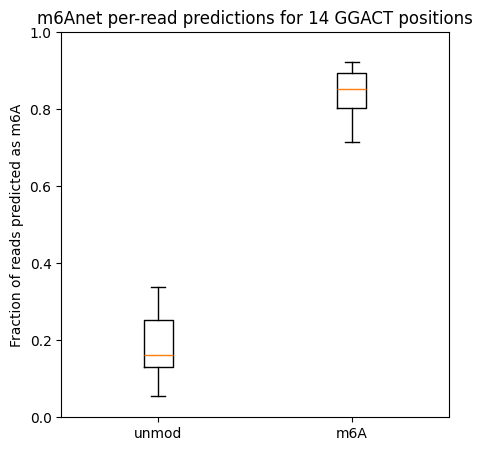

In [54]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.boxplot(freqs, labels=["unmod", "m6A"])
ax.set_ylim(0, 1)
ax.set_ylabel("Fraction of reads predicted as m6A")
ax.set_title(f"m6Anet per-read predictions for {len(positions)} GGACT positions")
fig.savefig("m6Anet.boxplot.GGACT.pdf")

# mafia

### prepare bed for mafia

In [60]:
header = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand']
with open("curlcake.fa.bed", "wt") as out:
    out.write("\t".join(header)+"\n")
    name, score, strand = "m6A", 0, "+"
    for ref, pos in positions:
        out.write(f"{ref}\t{pos}\t{pos+1}\t{name}\t{score}\t{strand}\n")

In [61]:
!head curlcake.fa.bed

chrom	chromStart	chromEnd	name	score	strand
cc6m_2244_T7_ecorv	102	103	m6A	0	+
cc6m_2244_T7_ecorv	687	688	m6A	0	+
cc6m_2244_T7_ecorv	1386	1387	m6A	0	+
cc6m_2244_T7_ecorv	1965	1966	m6A	0	+
cc6m_2459_T7_ecorv	333	334	m6A	0	+
cc6m_2459_T7_ecorv	823	824	m6A	0	+
cc6m_2459_T7_ecorv	1700	1701	m6A	0	+
cc6m_2595_T7_ecorv	399	400	m6A	0	+
cc6m_2595_T7_ecorv	610	611	m6A	0	+
